steps:
- recalssify rasters into groups based on bins or stats
- convert the reclassified rasters to vectors
- reclassification using vectors
- use Kmeans as first pass with minimum area for a class (to avoid tiny blobs)
- use sklearn image classifiers to shorthand the work


Note on stratification - this POC does not include the step fo first excluding areas with 20% or greater tree cover (which cannot be included for carbon projects). This POC just builds out the basic backbone of notebooks that allow us to input several rasters and person some terrain analysis, geometric operations and data reclassification to get a series of polygons representing 'similar areas' within the procided area of interest. 

In [27]:
%pip install scikit-learn -q
%pip install scikit-image -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [28]:
import os
import numpy as np
import geopandas as gpd
import rasterio
import rioxarray

import xarray as xr

from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import grid_to_graph

from skimage.morphology import opening, square, white_tophat, disk, remove_small_objects, remove_objects_by_distance, closing
from skimage import measure
from skimage import feature
from skimage import filters
from skimage.filters import median
from skimage.filters import meijering, sato, frangi, hessian

import matplotlib.pyplot as plt


In [36]:
input_dir = "/workspace/notebooks/sandbox/data/stratification/stratification_results"
output_dir = "/workspace/notebooks/sandbox/data/stratification/stratification_results"

raw_classification = rioxarray.open_rasterio(os.path.join(input_dir, "kmeans_draft.tiff"))

raw_classification


<xarray.DataArray (band: 1, y: 492, x: 625)> Size: 1MB
[307500 values with dtype=int32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 5kB 1.294e+07 1.294e+07 ... 1.296e+07 1.296e+07
  * y            (y) float64 4kB -3.404e+06 -3.404e+06 ... -3.415e+06 -3.415e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
raw_classification_T = raw_classification.transpose('y', 'x', 'band')
raw_classification_T =  raw_classification_T.squeeze()

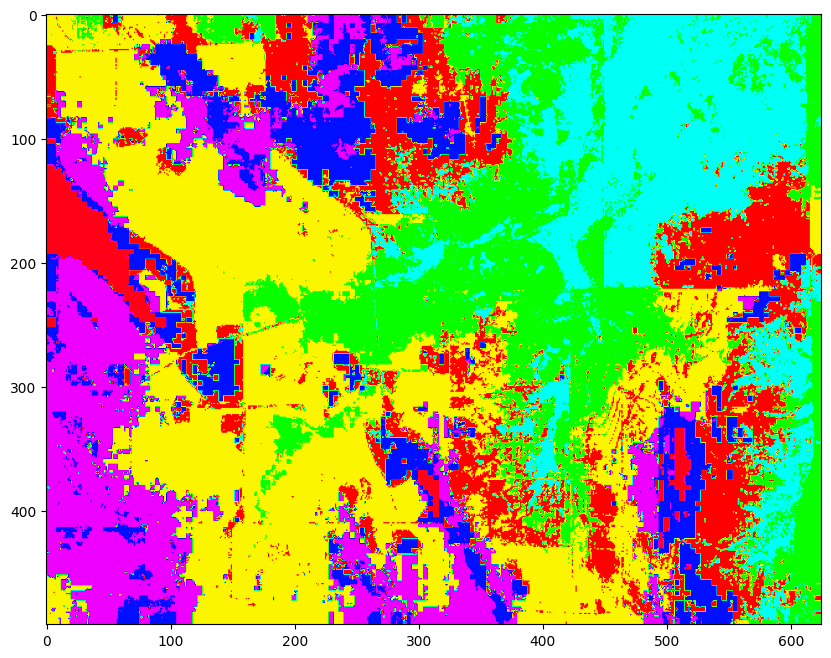

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(raw_classification_T, cmap='hsv')

In [31]:
image = raw_classification_T

disk_size = 3

cleaned_opening = opening(image, square(disk_size))

cleaned_closing = closing(image, square(disk_size))

median_filter = filters.median(image, disk(disk_size))

median_closing = filters.median(cleaned_closing, disk(disk_size))

median_opening = filters.median(cleaned_opening, disk(disk_size))

opening_closing = closing(opening(image, square(disk_size)), square(disk_size))

median_opening_closing = filters.median(closing(median_opening, disk(disk_size)))

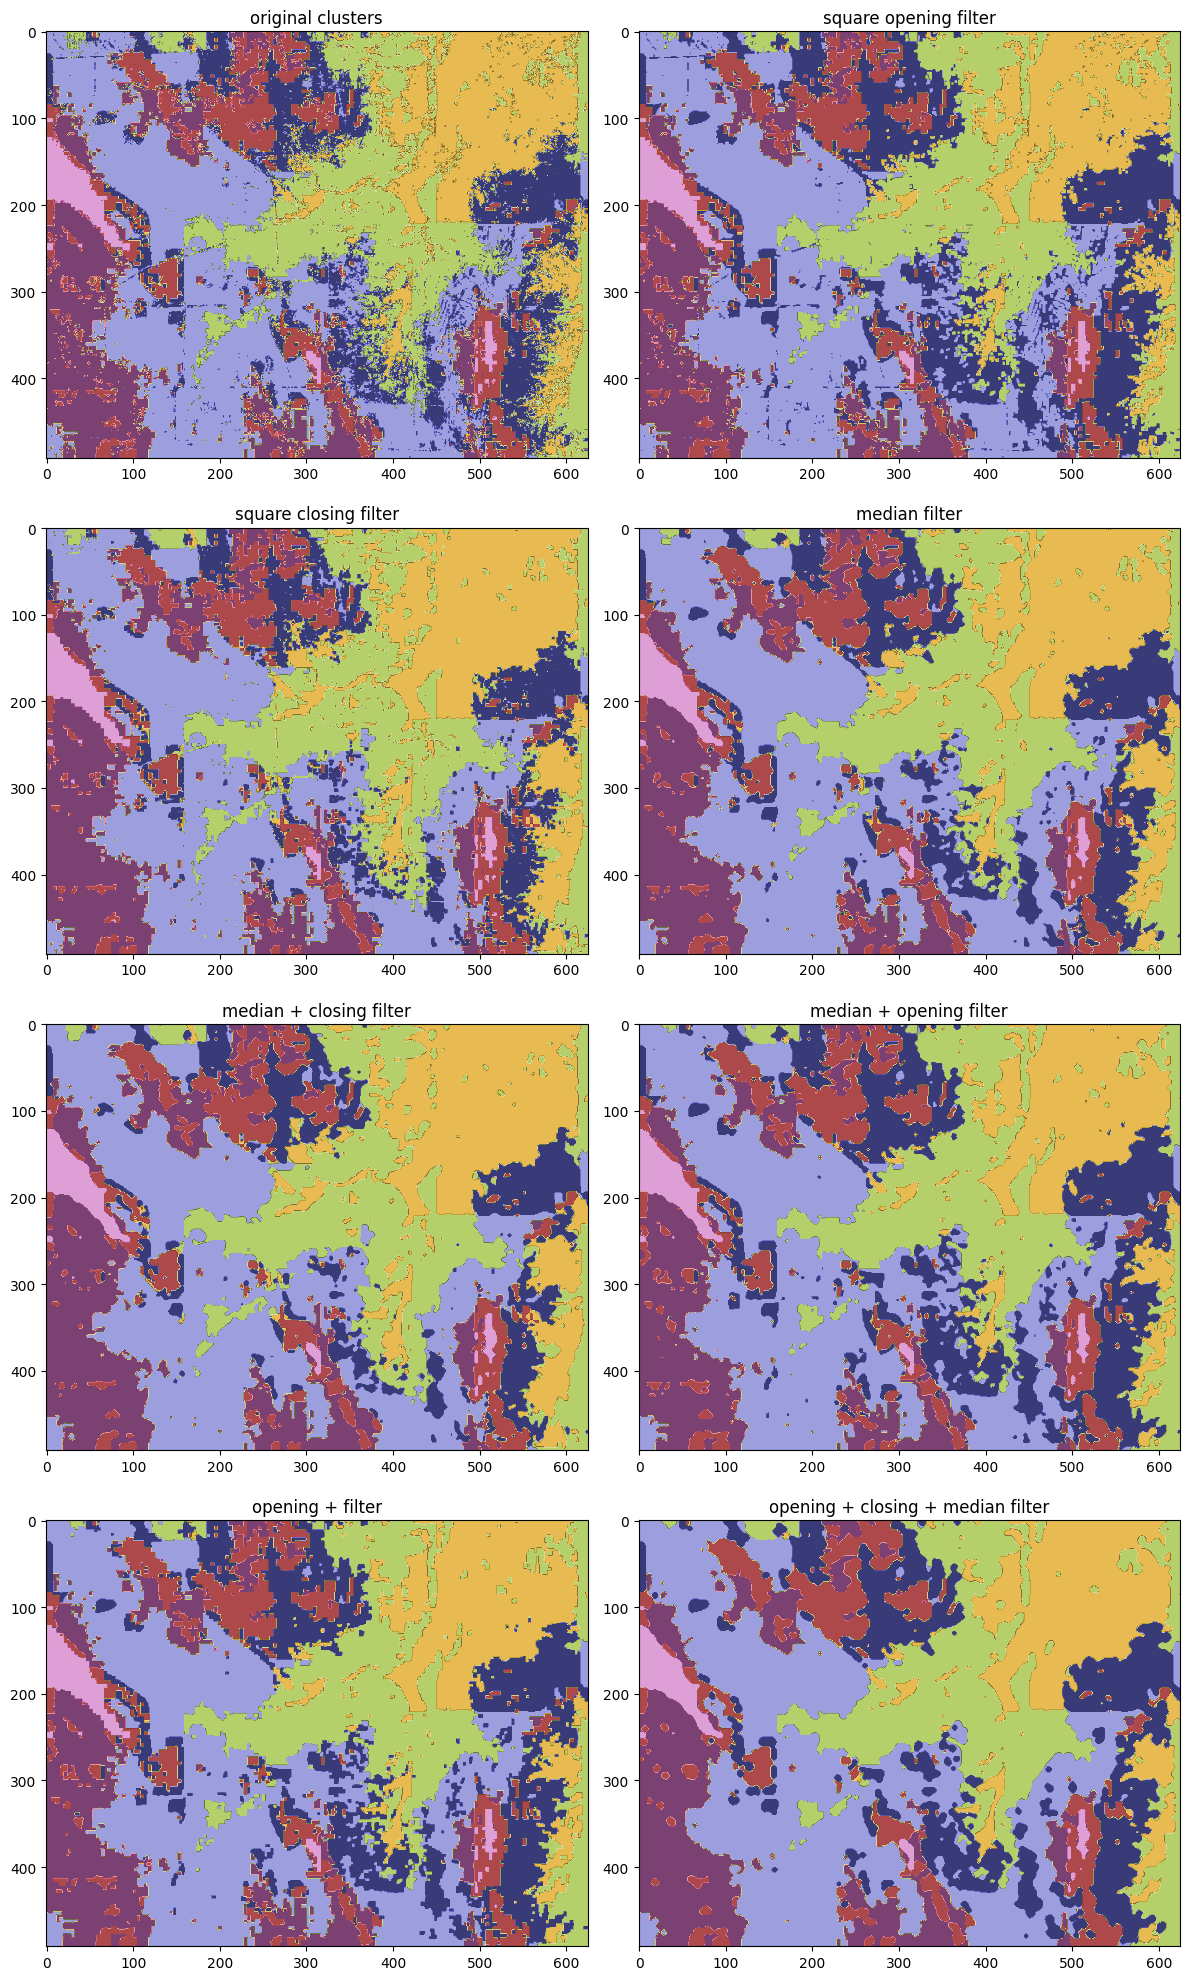

In [32]:
n_rows = 4
n_cols=2

# display results
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*6, n_rows*5))

ax[0,0].imshow(image, cmap='tab20b')
ax[0,0].set_title(r'original clusters')

ax[0,1].imshow(cleaned_opening, cmap='tab20b')
ax[0,1].set_title(r'square opening filter')

ax[1,0].imshow(cleaned_closing, cmap='tab20b')
ax[1,0].set_title(r'square closing filter')

ax[1,1].imshow(median_filter, cmap='tab20b')
ax[1,1].set_title(r'median filter')

ax[2,0].imshow(median_closing, cmap='tab20b')
ax[2,0].set_title(r'median + closing filter')

ax[2,1].imshow(median_opening, cmap='tab20b')
ax[2,1].set_title(r'median + opening filter')

ax[3,0].imshow(opening_closing, cmap='tab20b')
ax[3,0].set_title(r'opening + filter')

ax[3,1].imshow(median_opening_closing, cmap='tab20b')
ax[3,1].set_title(r'opening + closing + median filter')


fig.tight_layout()
plt.show()

In [ ]:
processed_clas = xr.DataArray(
    median_opening_closing, 
    coords={
        'y': raw_classification_T.coords['y'],
        'x': raw_classification_T.coords['x']
    },
    dims=['y', 'x']
)
processed_clas.rio.write_crs(raw_classification_T.rio.crs, inplace=True)